<a href="https://colab.research.google.com/github/shielamms/AI-and-Data-Analysis/blob/master/Tensorflow_for_Classification_of_Flower_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import glob
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [ ]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname='flower_photos.tgz',
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 6s 0us/step


In [ ]:
!find $base_dir -type d -print

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/roses


In [ ]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [ ]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')

  print("{}: {} Images".format(cl, len(images)))

  # Put the first 80% of data in train, last 20% in val
  train, val = images[:round(len(images) * 0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))

    shutil.move(t, os.path.join(base_dir, 'train', cl))
  
  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    
    shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [ ]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [ ]:
print(train_dir, val_dir)

/root/.keras/datasets/flower_photos/train /root/.keras/datasets/flower_photos/val


### Data Augmentation through Image Transformations

In [ ]:
batch_size = 100
IMG_SHAPE = 150

#### Random Horizontal Flip

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(
    batch_size = batch_size,
    directory = train_dir,
    shuffle = True,
    target_size=(IMG_SHAPE, IMG_SHAPE)
)

Found 2935 images belonging to 5 classes.


In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()

  for img, ax in zip(images_arr, axes):
    ax.imshow(img)

  plt.tight_layout()
  plt.show()

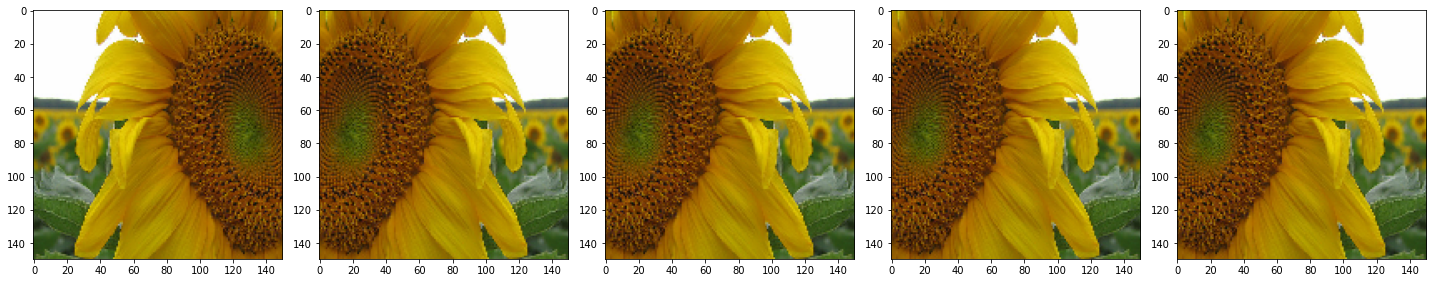

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Random Rotation

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_image_gen = image_gen.flow_from_directory(
    batch_size = batch_size,
    directory = train_dir,
    shuffle = True,
    target_size = (IMG_SHAPE, IMG_SHAPE)
)

Found 2935 images belonging to 5 classes.


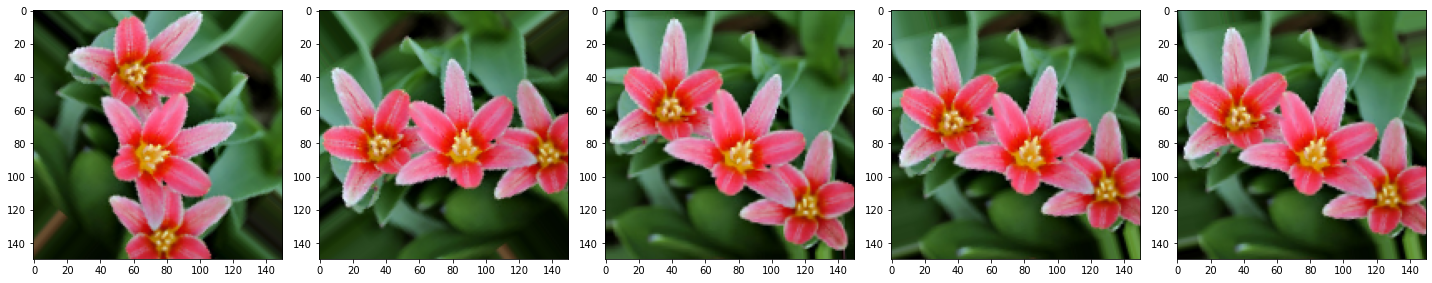

In [ ]:
augmented_images = [train_image_gen[0][0][0] for i in range (5)]
plotImages(augmented_images)

#### Random Zoom

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(
    batch_size = batch_size,
    directory = train_dir,
    shuffle = True,
    target_size = (IMG_SHAPE, IMG_SHAPE)
)

Found 2935 images belonging to 5 classes.


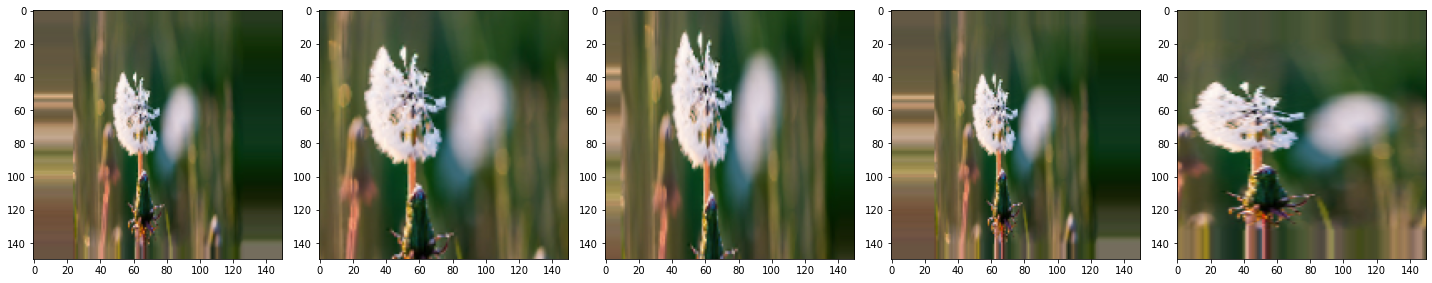

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

#### Putting it all together

In [ ]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory = train_dir,
    shuffle = True,
    target_size = (IMG_SHAPE, IMG_SHAPE),
    class_mode = 'sparse'
)

Found 2935 images belonging to 5 classes.


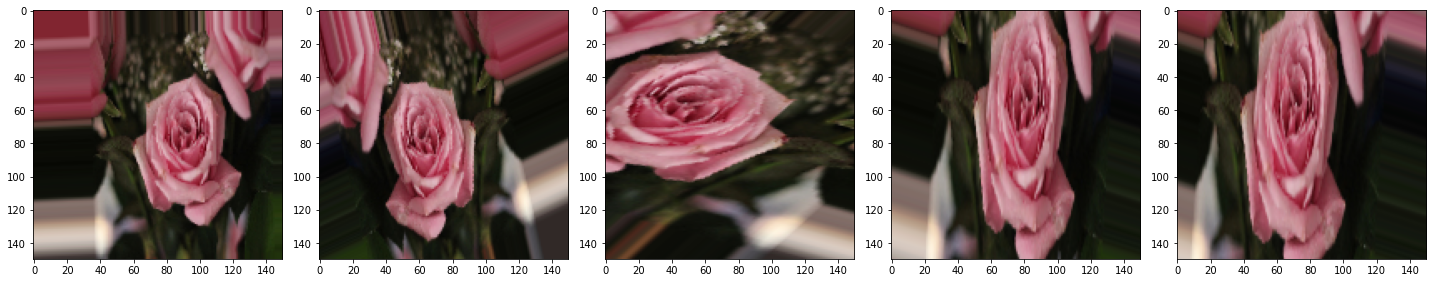

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Transforming the validation set

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(
    batch_size = batch_size,
    directory = val_dir,
    target_size = (IMG_SHAPE, IMG_SHAPE),
    class_mode = 'sparse'
)

Found 735 images belonging to 5 classes.


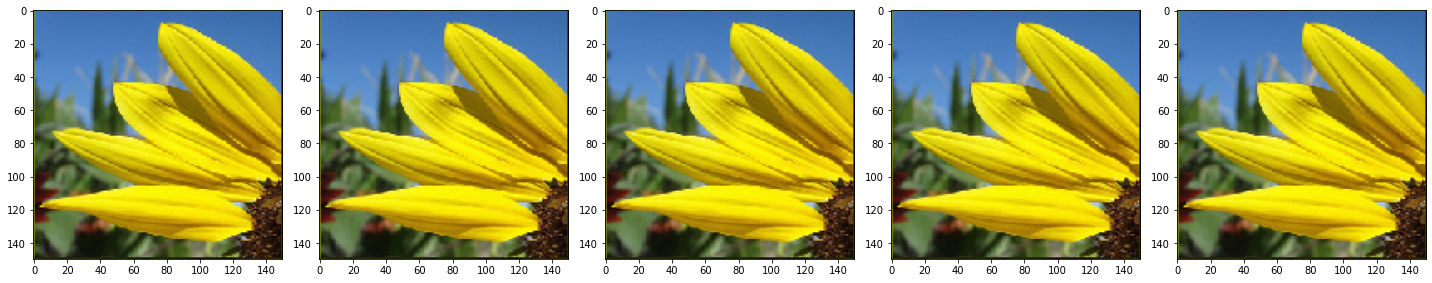

In [ ]:
augmented_val_imgs = [val_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_val_imgs)

### Create the CNN

In [ ]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5))

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training

In [ ]:
epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps = int(np.ceil(val_data_gen.n / float(batch_size)))
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
30/30 [==============================] - 21s 692ms/step - loss: 1.6017 - accuracy: 0.3319 - val_loss: 1.2503 - val_accuracy: 0.4721
Epoch 2/80
30/30 [==============================] - 21s 695ms/step - loss: 1.2156 - accuracy: 0.4985 - val_loss: 1.1206 - val_accuracy: 0.5537
Epoch 3/80
30/30 [==============================] - 21s 692ms/step - loss: 1.1062 - accuracy: 0.5581 - val_loss: 1.1152 - val_accuracy: 0.5741
Epoch 4/80
30/30 [==============================] - 21s 690ms/step - loss: 1.0213 - accuracy: 0.6055 - val_loss: 1.0716 - val_accuracy: 0.5878
Epoch 5/80
30/30 [==============================] - 21s 698ms/step - loss: 0.9890 - accuracy: 0.6116 - val_loss: 0.9606 - val_accuracy: 0.6313
Epoch 6/80
30/30 [==============================] - 21s 699ms/step - loss: 0.9532 - accuracy: 0.6184 - val_loss: 0.9253 - val_accuracy: 0.6327
Epoch 7/80
30/30 [==============================] - 21s 693ms/step

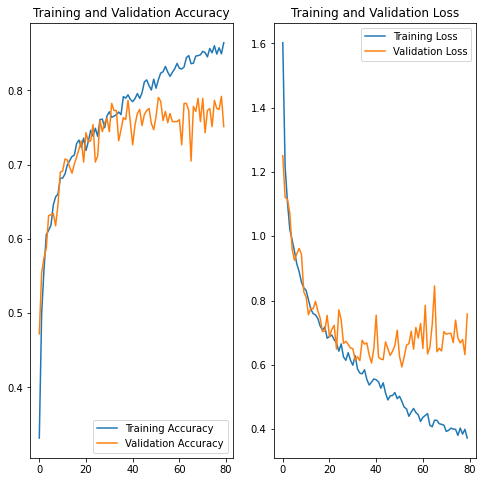

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()